In [1]:
!pip install ktrain datasets accelerate transformers -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 21.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 30.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing met

In [23]:
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import ktrain
from ktrain import text
import joblib
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.utils import resample
from imblearn.under_sampling import NearMiss
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from datasets import Dataset, DatasetDict

**LOAD DATA**

In [3]:
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/SatriaData/dataset.csv'

Mounted at /content/drive


In [4]:
df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,text,label,label_num
0,0,kunjung prabowo resmi serah proyek bantu air b...,Sumber Daya Alam,0
1,1,anies tepuk tangan riah rektor wajib mata kuli...,Politik,1
2,2,emng bener dukung 01 goblok dukung 02 hnya sj ...,Demografi,2
3,3,waktu anies sikap kritis kerja pak prabowo ang...,Politik,1
4,4,anies baswedan harap asn masuk tni polri pegan...,Politik,1


In [5]:
df = df.drop(columns=['Unnamed: 0'])
df.isna().sum()

text         0
label        0
label_num    0
dtype: int64

In [6]:
label_counts = df['label_num'].value_counts()

print(label_counts)

label_num
1    2969
6     584
3     400
4     400
5     366
0     191
2      62
7      19
Name: count, dtype: int64


In [7]:
#Melakukan balancing data dengan oversampling
df_majority = df[df['label_num'] == 1]
upsampled_minority_classes = []
for label_num in range(0, 8):
  if label_num == 1:
    continue
  else:
    df_minority = df[df['label_num'] == label_num]
    df_minority_upsampled = resample(df_minority,
                                     replace=True,
                                     n_samples=len(df_majority),
                                     random_state=42)
    upsampled_minority_classes.append(df_minority_upsampled)


df_upsampled = pd.concat([df_majority] + upsampled_minority_classes)

In [8]:
label_counts = df_upsampled['label_num'].value_counts()

print(label_counts)

label_num
1    2969
0    2969
2    2969
3    2969
4    2969
5    2969
6    2969
7    2969
Name: count, dtype: int64


In [9]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_upsampled['text'])
Y = df_upsampled['label_num']

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

joblib.dump(vectorizer, '/content/drive/My Drive/SatriaData/tfidf_vectorizer.pkl')

['/content/drive/My Drive/SatriaData/tfidf_vectorizer.pkl']

### **NB MULTINOMIAL**

Accuracy: 0.9223321406019785
Classification Multinomial NB Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       632
           1       0.93      0.77      0.84       563
           2       0.93      0.97      0.95       580
           3       0.95      0.95      0.95       567
           4       0.94      0.89      0.91       605
           5       0.86      0.94      0.90       573
           6       0.91      0.92      0.92       633
           7       0.99      1.00      0.99       598

    accuracy                           0.92      4751
   macro avg       0.92      0.92      0.92      4751
weighted avg       0.92      0.92      0.92      4751



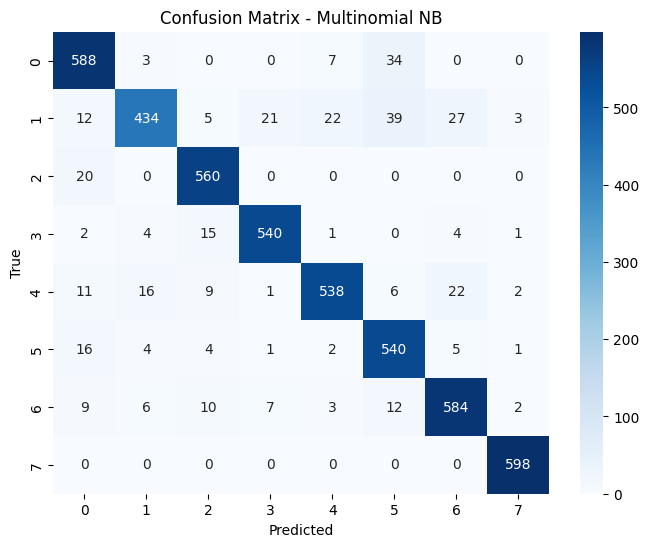

['/content/drive/My Drive/SatriaData/NB_Multinomial_model.pkl']

In [10]:
nb_model = MultinomialNB()
nb_model.fit(X,Y)
Y_pred = nb_model.predict(X_val)

accuracy = accuracy_score(Y_val, Y_pred)
report = classification_report(Y_val, Y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Multinomial NB Report:')
print(report)

conf_matrix = confusion_matrix(Y_val, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Multinomial NB')
plt.show()

joblib.dump(nb_model, '/content/drive/My Drive/SatriaData/NB_Multinomial_model.pkl')

# ***KNN***

Accuracy: 0.9600084192801516
Classification KNN Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       632
           1       0.98      0.80      0.89       563
           2       0.97      0.97      0.97       580
           3       0.96      0.98      0.97       567
           4       0.95      0.98      0.97       605
           5       0.96      0.96      0.96       573
           6       0.94      0.97      0.96       633
           7       1.00      1.00      1.00       598

    accuracy                           0.96      4751
   macro avg       0.96      0.96      0.96      4751
weighted avg       0.96      0.96      0.96      4751



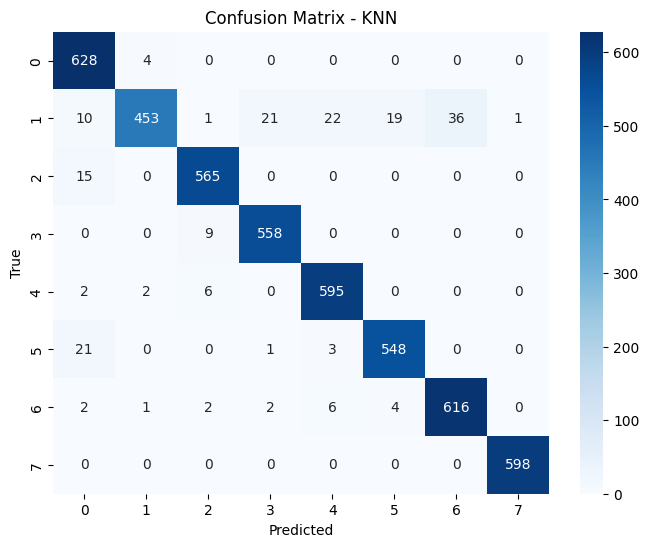

['/content/drive/My Drive/SatriaData/knn_model.pkl']

In [11]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X,Y)
Y_pred = knn_model.predict(X_val)

accuracy = accuracy_score(Y_val, Y_pred)
report = classification_report(Y_val, Y_pred)

print(f'Accuracy: {accuracy}')
print('Classification KNN Report:')
print(report)

conf_matrix = confusion_matrix(Y_val, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - KNN')
plt.show()

joblib.dump(nb_model, '/content/drive/My Drive/SatriaData/knn_model.pkl')

# INDOBERT

In [12]:
model_name = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=8)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

In [13]:
dataset = Dataset.from_pandas(df_upsampled[['text','label_num']])
dataset = dataset.rename_column('label_num', 'label')

dataset = dataset.train_test_split(test_size=0.2)

In [18]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/19001 [00:00<?, ? examples/s]

Map:   0%|          | 0/4751 [00:00<?, ? examples/s]

In [19]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [20]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [21]:
trainer.train()

{'loss': 0.455, 'grad_norm': 3.8348324298858643, 'learning_rate': 1.719416386083053e-05, 'epoch': 0.4208754208754209}
{'loss': 0.2506, 'grad_norm': 13.678618431091309, 'learning_rate': 1.4388327721661056e-05, 'epoch': 0.8417508417508418}
{'eval_loss': 0.16416992247104645, 'eval_runtime': 34.6961, 'eval_samples_per_second': 136.932, 'eval_steps_per_second': 8.56, 'epoch': 1.0}
{'loss': 0.1552, 'grad_norm': 12.52719783782959, 'learning_rate': 1.1582491582491585e-05, 'epoch': 1.2626262626262625}
{'loss': 0.1106, 'grad_norm': 0.05592180788516998, 'learning_rate': 8.77665544332211e-06, 'epoch': 1.6835016835016834}
{'eval_loss': 0.15903562307357788, 'eval_runtime': 35.2596, 'eval_samples_per_second': 134.743, 'eval_steps_per_second': 8.423, 'epoch': 2.0}
{'loss': 0.086, 'grad_norm': 0.04187265783548355, 'learning_rate': 5.970819304152637e-06, 'epoch': 2.1043771043771042}
{'loss': 0.064, 'grad_norm': 0.4163513481616974, 'learning_rate': 3.1649831649831652e-06, 'epoch': 2.525252525252525}
{'lo

TrainOutput(global_step=3564, training_loss=0.1655629827786241, metrics={'train_runtime': 1463.1135, 'train_samples_per_second': 38.96, 'train_steps_per_second': 2.436, 'train_loss': 0.1655629827786241, 'epoch': 3.0})

In [25]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.12012547254562378, 'eval_runtime': 34.0844, 'eval_samples_per_second': 139.389, 'eval_steps_per_second': 8.714, 'epoch': 3.0}
{'eval_loss': 0.12012547254562378, 'eval_runtime': 34.0844, 'eval_samples_per_second': 139.389, 'eval_steps_per_second': 8.714, 'epoch': 3.0}


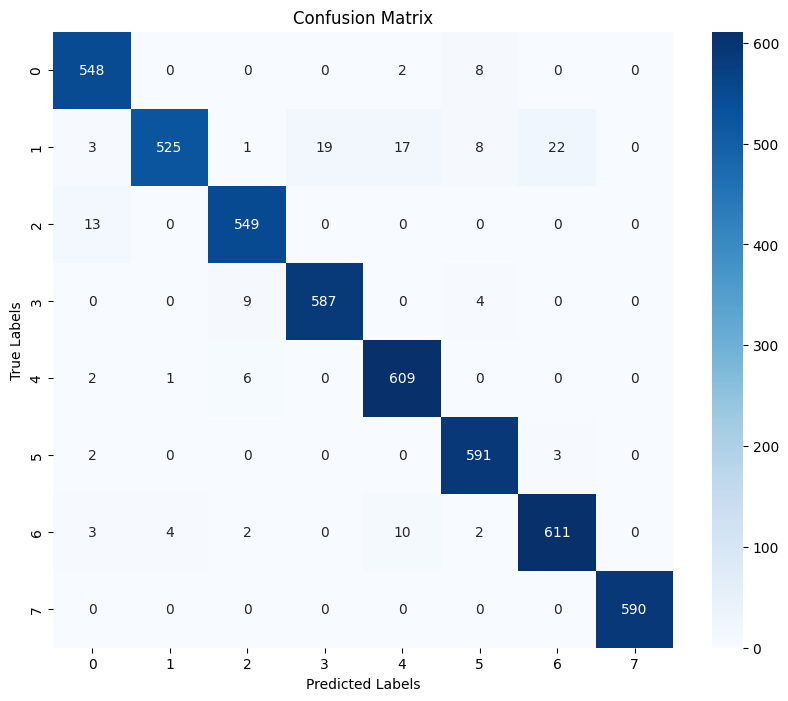


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       558
           1       0.99      0.88      0.93       595
           2       0.97      0.98      0.97       562
           3       0.97      0.98      0.97       600
           4       0.95      0.99      0.97       618
           5       0.96      0.99      0.98       596
           6       0.96      0.97      0.96       632
           7       1.00      1.00      1.00       590

    accuracy                           0.97      4751
   macro avg       0.97      0.97      0.97      4751
weighted avg       0.97      0.97      0.97      4751



In [26]:

predictions = trainer.predict(tokenized_datasets['test'])

predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = tokenized_datasets['test']['label']

conf_matrix = confusion_matrix(true_labels, predicted_labels)

class_report = classification_report(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(true_labels),
            yticklabels=np.unique(true_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(class_report)